# Datos oceanográficos de boyas perfiladoras de la Red Argo con `argopy`

[Hackatón de OceanHackWeek en Español 2025](https://intercoonecta.github.io/ohw2025.html). 2025-11-26 (con cambios, 2025-12-08)

En este tutorial exploramos los datos de las boyas perfiladoras que forman parte de la [red global Argo](https://argo.ucsd.edu), utilizando el paquete [argopy](https://argopy.readthedocs.io) en Python. El tutorial incluye la definición de una búsqueda de datos existentes, descarga de los datos y transformación a `Dataset` de `xarray`, creación de gráficas con funciones de `argopy` y funciones más básicas de `xarray`, `matplotlib` y `cartopy`, y algunos procesamientos y análisis enfocados en la Profundidad de la Capa de Mezcla ("Mixed Layer Depth", MLD). Todo, usando como ejemplo motivador **la zona de afloramiento del Chorro de Papagayo en la costa Pacífico de Nicaragua y Costa Rica.**

**El cuaderno asociado a este, [DatosArgo-trasfondo-AfloramientoPapagayo.ipynb](DatosArgo-trasfondo-AfloramientoPapagayo.ipynb), presenta una breve reseña sobre la [red global Argo](https://argo.ucsd.edu), las boyas perfiladoras usadas en la red, mi trabajo relevante para este tipo de datos, y la región de interés (el [afloramiento del Chorro de Papagayo](https://1library.co/article/golfo-papagayo-ambientes-marino-costeros-costa-rica.zp6gl47q)).**


**Fuentes de información y entrenamiento adicional sobre `argopy` y la red Argo**

Gran parte del material para este tutorial fue adaptado de estas fuentes, que ofrecen guías y tutoriales extensos:

- Sitio web de red Argo: https://argo.ucsd.edu
- `argopy`: https://argopy.readthedocs.io
- Entrenamiento con `argopy`: https://github.com/euroargodev/argopy-training
- Argo Online School: https://www.euro-argo.eu/argo-online-school/intro.html

## Importar librerías

In [1]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cmocean  # Mapas de colores disenado para variables oceanograficas
import matplotlib.pyplot as plt
import numpy as np

# Funciones de argopy que usaremos directamente
from argopy import DataFetcher
from argopy.plot import scatter_map, scatter_plot

## Seleccionar y descargar datos de Argo por "región"

Utilizaremos la función (`clase`) [DataFetcher (↗)](https://argopy.readthedocs.io/en/v1.3.1/generated/argopy.fetchers.ArgoDataFetcher.html#argopy.fetchers.ArgoDataFetcher) para definir el dominio (extensión) espacio-temporal de la búsqueda y crear la variable (objeto) `cargador`. El dominio define la extensión en latitud, longitud, profundidad, y tiempo.

(Aquí he utilizado el sitio http://bboxfinder.com para ayudarme a definir el rectángulo delimitador de latidudes y longitudes para una **región alrededor del afloramiento del Chorro de Papagayo:** http://bboxfinder.com/#8,-91,12,-86)

`DataFetcher` ofrece las siguientes opciones, que no exploraremos aquí sino que usaremos los valores por defecto:
- modo de usuario (`mode`). Niveles de post-procesamiento: "expert", "standard" (defecto), "research"
- proveedor de datos (`src`). Fuente donde obtener los datos, incluyendo cache local
- datasets (`ds`). "phy", parámetros físicos (defecto), o "bgc", parámetros biogeoquímicos de Argo BGC

In [2]:
%%time

cargador = DataFetcher(cache=True, parallel=True).region([
    -91, -86,  # longitud
    8, 12,     # latitud
    0, 700,    # profundidad. 
               # Para reducir el tamaño de la descarga, no pedimos el perfil completo
    '2005-01-01', '2025-11-30'  # fechas / tiempo (la fecha máxima es exclusiva)
])

CPU times: user 11.2 ms, sys: 951 μs, total: 12.2 ms
Wall time: 11.6 ms


Ese paso fue muy rápido porque aún no hemos descargado los datos. Sólo definimos los parámetros de la búsqueda, con algunas decisiones (valores) explícitas y otras implícitas (por defecto). 

Ahora descargamos los datos con el método `.data`, **convirtiéndolos a un `Dataset` de `xarray` organizados como "puntos".** Al ejecutar este método, el `Dataset` no sólo es copiado a la variable `punto_ds`, también es almazanedo internamente en el objecto `cargador`:

In [3]:
%%time

puntos_ds = cargador.data

puntos_ds.argo

CPU times: user 12.8 s, sys: 2.05 s, total: 14.9 s
Wall time: 34.7 s


<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(241805) ~ N_PROF(813) x N_LEVELS(551)

El método `.argo` da un resumen de la colección de observaciones en puntos que hemos descargado: 812 perfiles conteniendo 241,455 puntos en hasta 551 niveles de profundidad.

### Explorar los datos de puntos

Ahora exploremos el `Dataset` de xarray para ver más detalles. El `Dataset` tiene una sola dimensión, `N_POINTS`, los puntos; variables de temperatura, salinidad, presión, de evaluación de control de calidad, e información sobre la boya y la fase en el ciclo de perfilación. También contiene metadatos sobre cómo y cuando se descargaron los datos, y el procesamiento anterior de los datos.

In [4]:
puntos_ds

<xarray.Dataset> Size: 29MB
Dimensions:          (N_POINTS: 241805)
Coordinates:
  * N_POINTS         (N_POINTS) int64 2MB 0 1 2 3 ... 241802 241803 241804
    LATITUDE         (N_POINTS) float64 2MB 10.0 10.0 10.0 ... 10.61 10.61 10.61
    LONGITUDE        (N_POINTS) float64 2MB -87.0 -87.0 -87.0 ... -88.04 -88.04
    TIME             (N_POINTS) datetime64[ns] 2MB 2005-12-07T10:36:00 ... 20...
Data variables: (12/15)
    CYCLE_NUMBER     (N_POINTS) int64 2MB 0 0 0 0 0 0 ... 260 260 260 260 260
    DATA_MODE        (N_POINTS) <U1 967kB 'R' 'R' 'R' 'R' ... 'A' 'A' 'A' 'A'
    DIRECTION        (N_POINTS) <U1 967kB 'D' 'D' 'D' 'D' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_POINTS) int64 2MB 1900379 1900379 ... 3901300 3901300
    POSITION_QC      (N_POINTS) int64 2MB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    PRES             (N_POINTS) float32 967kB 45.0 55.0 65.0 ... 698.3 700.3
    ...               ...
    PSAL_ERROR       (N_POINTS) float32 967kB nan nan nan nan ... nan nan nan
    PSAL_QC          (N_POINTS) int64 2MB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TEMP             (N_POINTS) float32 967kB 15.76 14.86 14.59 ... 6.621 6.615
    TEMP_ERROR       (N_POINTS) float32 967kB nan nan nan nan ... nan nan nan
    TEMP_QC          (N_POINTS) int64 2MB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TIME_QC          (N_POINTS) int64 2MB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           mayorga
    Fetched_date:         2025/11/26
    Fetched_constraints:  [x=-91.00/-86.00; y=8.00/12.00; z=0.0/350.0; t=2005...
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

Objetos de [DataFetcher (↗)](https://argopy.readthedocs.io/en/v1.3.1/generated/argopy.fetchers.ArgoDataFetcher.html#argopy.fetchers.ArgoDataFetcher) proveen varias capacidades útiles, incluyendo gráficas de uso común. Veamos el dominio, luego un mapa de los puntos:

In [5]:
cargador.domain

[np.float64(-90.985),
 np.float64(-86.00025177001953),
 np.float64(8.0036),
 np.float64(11.974305333333332),
 np.float32(0.1),
 np.float32(701.1),
 np.datetime64('2005-12-07T10:36:00.000000000'),
 np.datetime64('2025-11-25T07:15:39.000000000')]

En este mapa, cada boya es representada por un color, con su secuencia de puntos conectados con líneas.

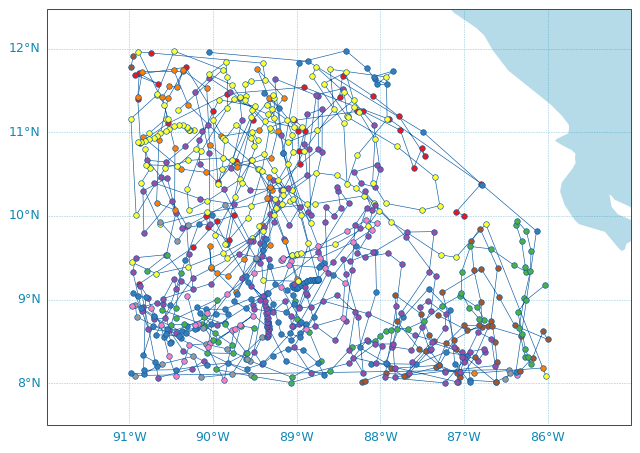

In [6]:
cargador.plot('trajectory', markersize=20, legend=False, padding=[1.0, 0.5]);

Como es un `Dataset` de xarray, también podemos hacer gráficas directamente con xarray. Aquí vemos un histograma de las profundidades:

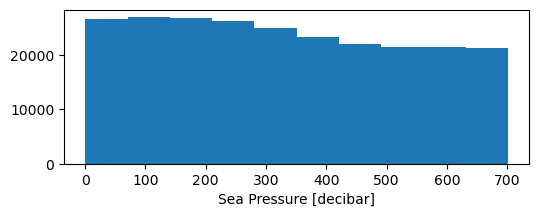

In [7]:
puntos_ds['PRES'].plot.hist(figsize=(6,2));

`DataFetcher` también nos permite hacer gráficas de una propiedad contra otra. Aqui, un plot convencional oceanografico de profundidad en función de temperatura y salinidad.

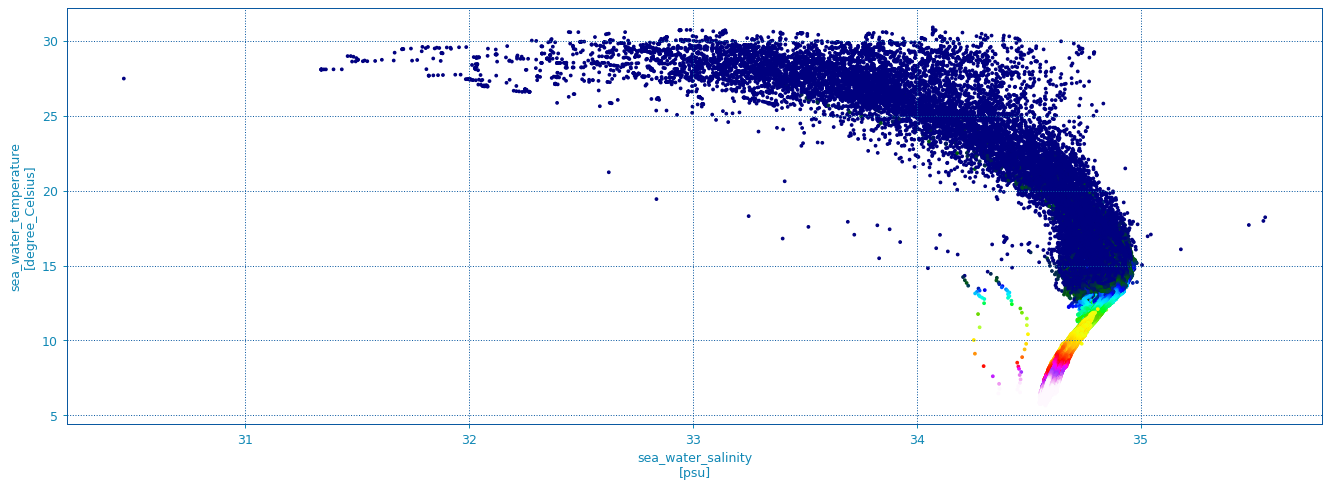

In [8]:
cargador.plot('PRES', this_x='PSAL', this_y='TEMP');

Podemos mejorar ese plot con una barra de color, dimensiones más cuadradas, y otros cambios. Vamos a usar una paleta ("mapa") de colores del paquete `cmocean` que contiene colores personalizados para aplicaciones oceanográficas.

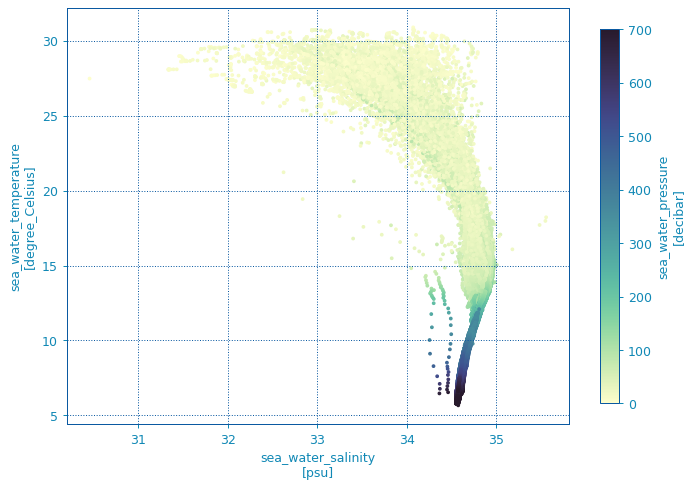

In [9]:
cargador.plot(
    'PRES', this_x='PSAL', this_y='TEMP',
    vmin=0, vmax=700, cmap=cmocean.cm.deep, cbar=True, figsize=(9, 6)
);

## Reorganizar los datos por perfil

Podemos transformar (reoganizar) los datos de colección de puntos a una estructura de colección de perfiles por profundidad, con el método `argo.point2profile()` que es parte de `argopy`. Luego veamos las diferencias en organización de los datos.

In [10]:
perfiles_ds = puntos_ds.argo.point2profile()

perfiles_ds.argo

<xarray.Dataset.argo>
This is a collection of Argo profiles
N_PROF(813) x N_LEVELS(551) ~ N_POINTS(447963)

Nota: Ahora hay más puntos (`N_POINTS`) que antes. Todavia no sé por qué ....

In [11]:
perfiles_ds

<xarray.Dataset> Size: 11MB
Dimensions:          (N_PROF: 813, N_LEVELS: 551)
Coordinates:
  * N_PROF           (N_PROF) int64 7kB 25 26 295 296 27 ... 91 369 806 155 294
  * N_LEVELS         (N_LEVELS) int64 4kB 0 1 2 3 4 5 ... 546 547 548 549 550
    LATITUDE         (N_PROF) float64 7kB 10.0 10.05 8.145 ... 9.048 9.447 10.61
    LONGITUDE        (N_PROF) float64 7kB -87.0 -87.09 -87.23 ... -90.97 -88.04
    TIME             (N_PROF) datetime64[ns] 7kB 2005-12-07T10:36:00 ... 2025...
Data variables: (12/15)
    CYCLE_NUMBER     (N_PROF) int64 7kB 0 0 82 83 36 37 ... 155 27 27 21 26 260
    DATA_MODE        (N_PROF) <U1 3kB 'R' 'R' 'D' 'D' 'D' ... 'R' 'A' 'R' 'A'
    DIRECTION        (N_PROF) <U1 3kB 'D' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_PROF) int64 7kB 1900379 1900379 ... 2903904 3901300
    POSITION_QC      (N_PROF) int64 7kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PRES             (N_PROF, N_LEVELS) float32 2MB 45.0 55.0 65.0 ... nan nan
    ...               ...
    PSAL_ERROR       (N_PROF, N_LEVELS) float32 2MB nan nan nan ... nan nan nan
    PSAL_QC          (N_PROF) int64 7kB 1 1 2 2 1 1 2 1 1 ... 1 1 1 1 1 1 1 1 1
    TEMP             (N_PROF, N_LEVELS) float32 2MB 15.76 14.86 ... nan nan
    TEMP_ERROR       (N_PROF, N_LEVELS) float32 2MB nan nan nan ... nan nan nan
    TEMP_QC          (N_PROF) int64 7kB 1 1 2 2 1 1 2 1 1 ... 1 1 1 1 1 1 1 1 1
    TIME_QC          (N_PROF) int64 7kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           mayorga
    Fetched_date:         2025/11/26
    Fetched_constraints:  [x=-91.00/-86.00; y=8.00/12.00; z=0.0/350.0; t=2005...
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

Podemos ver que ahora las dimensiones son los perfiles (`N_PROF`) y los niveles de profundidad (`N_LEVELS`).

### Calcular densidad, σ<sub>0</sub>

Calculemos la densidad, como la anomalía de densidad potencial, σ<sub>0</sub>. El cálculo está integrado en `argopy`, y la nueva variable 'SIG0' es añadida a `perfiles_ds` como un nuevo `DataArray`:

In [12]:
perfiles_ds.argo.teos10(['SIG0'])

<xarray.Dataset> Size: 14MB
Dimensions:          (N_PROF: 813, N_LEVELS: 551)
Coordinates:
  * N_PROF           (N_PROF) int64 7kB 25 26 295 296 27 ... 91 369 806 155 294
  * N_LEVELS         (N_LEVELS) int64 4kB 0 1 2 3 4 5 ... 546 547 548 549 550
    LATITUDE         (N_PROF) float64 7kB 10.0 10.05 8.145 ... 9.048 9.447 10.61
    LONGITUDE        (N_PROF) float64 7kB -87.0 -87.09 -87.23 ... -90.97 -88.04
    TIME             (N_PROF) datetime64[ns] 7kB 2005-12-07T10:36:00 ... 2025...
Data variables: (12/16)
    CYCLE_NUMBER     (N_PROF) int64 7kB 0 0 82 83 36 37 ... 155 27 27 21 26 260
    DATA_MODE        (N_PROF) <U1 3kB 'R' 'R' 'D' 'D' 'D' ... 'R' 'A' 'R' 'A'
    DIRECTION        (N_PROF) <U1 3kB 'D' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_PROF) int64 7kB 1900379 1900379 ... 2903904 3901300
    POSITION_QC      (N_PROF) int64 7kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PRES             (N_PROF, N_LEVELS) float32 2MB 45.0 55.0 65.0 ... nan nan
    ...               ...
    PSAL_QC          (N_PROF) int64 7kB 1 1 2 2 1 1 2 1 1 ... 1 1 1 1 1 1 1 1 1
    TEMP             (N_PROF, N_LEVELS) float32 2MB 15.76 14.86 ... nan nan
    TEMP_ERROR       (N_PROF, N_LEVELS) float32 2MB nan nan nan ... nan nan nan
    TEMP_QC          (N_PROF) int64 7kB 1 1 2 2 1 1 2 1 1 ... 1 1 1 1 1 1 1 1 1
    TIME_QC          (N_PROF) int64 7kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    SIG0             (N_PROF, N_LEVELS) float64 4MB 25.35 25.57 ... nan nan
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           mayorga
    Fetched_date:         2025/11/26
    Fetched_constraints:  [x=-91.00/-86.00; y=8.00/12.00; z=0.0/350.0; t=2005...
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

### Generar plots de perfiles oceanográficos

Con la organización de datos por perfil, podemos explorar más intituitivamente la estructura de la columna de agua. Primero enfoquémonos en un sólo perfil de una boya, escogido al azar (`N_PROF` con índice 500). Para esto vamos a combinar la funcionalidad de `Matplotlib` y de `xarray`, usando la presión ("PRES") como la variable en el eje vertical (y) y la variable de interés en el eje horizontal, y `yincrease=False` para que los valores de profundidad aumenten hacia abajo:

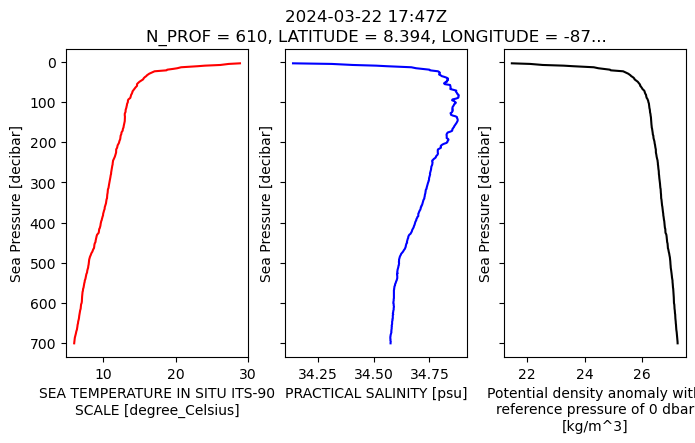

In [13]:
_, ax = plt.subplots(ncols=3, figsize=(8, 4), sharey=True)

perfil_i_ds = perfiles_ds.set_coords("PRES").isel(N_PROF=500)

perfil_i_ds['TEMP'].plot(ax=ax[0], y='PRES', yincrease=False, color='red')
ax[0].set_title(None)
perfil_i_ds['PSAL'].plot(ax=ax[1], y='PRES', yincrease=False, color='blue')
perfil_i_ds['SIG0'].plot(ax=ax[2], y='PRES', yincrease=False, color='black')
ax[2].set_title(None)

plt.suptitle(f"{perfil_i_ds.TIME.data.astype('datetime64[s]').item():%Y-%m-%d %H:%M}Z");

### Agregación de perfiles por mes, independiente del año

¡Un sólo perfil de una sola boya no es muy representativo! Tenemos datos de un área amplia a lo largo de 20 años. Ignorando la variabilidad interanual, vamos a contrastar la estructura vertical en enero, el mes con mayor afloramiento, y junio, un mes con afloramiento débil.

Primero confirmemos que tenemos una buena distribución de meses:

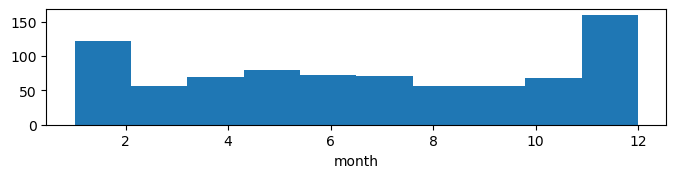

In [14]:
perfiles_ds['TIME.month'].plot.hist(figsize=(8, 1.5));

Ahora calculemos un nuevo `Dataset` donde cada variable es convertida a su promedio de todos los perfiles que ocurrieron en ese mes. Para hacer esto utilizamos la funcionalidad `groupby()` de `xarray` (ver el [tutorial sobre datos temporales en Python del Taller Intermedio](https://github.com/Intercoonecta/Talleres_intermedios/blob/ohwe25/6-Octubre-2025/datos_temporales_python/Intro_datos_temporales.ipynb)). Este procedimiento genera una nueva variable y dimensión, `month` (mes; el nombre es asignado automáticamente). Ahora las dimensiones del `Dataset` son `month` y `N_LEVELS` (índices de profundidad):

In [15]:
perfiles_mensuales_ds = perfiles_ds.groupby("TIME.month").mean()
# Le añadimos un atributo 'long_name' a la nueva variable 'month',
# para hacerlo un poco más entendible y útil
perfiles_mensuales_ds['month'].attrs = {'long_name': 'Mes'}

perfiles_mensuales_ds

<xarray.Dataset> Size: 217kB
Dimensions:          (month: 12, N_LEVELS: 551)
Coordinates:
  * month            (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * N_LEVELS         (N_LEVELS) int64 4kB 0 1 2 3 4 5 ... 546 547 548 549 550
Data variables: (12/14)
    CYCLE_NUMBER     (month) float64 96B 57.09 88.9 69.67 ... 105.9 63.96 73.58
    PLATFORM_NUMBER  (month) float64 96B 5.201e+06 5.075e+06 ... 4.43e+06
    POSITION_QC      (month) float64 96B 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    PRES             (month, N_LEVELS) float32 26kB 5.179 7.506 ... nan nan
    PRES_ERROR       (month, N_LEVELS) float32 26kB 2.384 2.384 ... nan nan
    PRES_QC          (month) float64 96B 1.0 1.0 1.0 1.0 ... 1.0 1.019 1.053
    ...               ...
    PSAL_QC          (month) float64 96B 1.0 1.0 1.0 1.0 ... 1.0 1.019 1.053
    TEMP             (month, N_LEVELS) float32 26kB 25.83 25.52 ... nan nan
    TEMP_ERROR       (month, N_LEVELS) float32 26kB 0.3403 0.277 ... nan nan
    TEMP_QC          (month) float64 96B 1.0 1.0 1.0 1.0 ... 1.0 1.019 1.053
    TIME_QC          (month) float64 96B 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    SIG0             (month, N_LEVELS) float64 53kB 22.24 22.35 ... nan nan
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           mayorga
    Fetched_date:         2025/11/26
    Fetched_constraints:  [x=-91.00/-86.00; y=8.00/12.00; z=0.0/350.0; t=2005...
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

/home/mayorga/miniconda3/envs/py-rocket-oceanhackweek/lib/python3.12/site-packages/matplotlib/colors.py:2243: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/mayorga/miniconda3/envs/py-rocket-oceanhackweek/lib/python3.12/site-packages/matplotlib/colors.py:2250: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


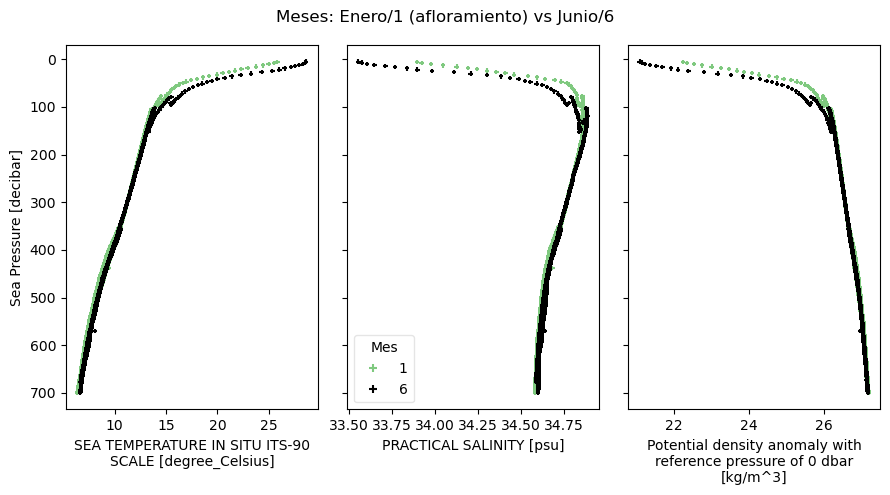

In [16]:
_, ax = plt.subplots(ncols=3, sharey=True, figsize=(9, 5))

# Tenemos que reasignar PRES como una coordenada. Y luego retenemos solamente enero y junio
perfiles_mensuales_sel_ds = perfiles_mensuales_ds.set_coords("PRES").sel(month=[1, 6])

# Este dictionario es un truco Pythonico para no tener que repetir
# todos estos argumentos en las funciones plot.scatter(), abajo
kwargs = dict(
    y='PRES', yincrease=False, 
    hue='month', marker='+', levels=2, s=10, alpha=1, 
    cmap='Accent',
    add_colorbar=False
)
perfiles_mensuales_sel_ds.plot.scatter(ax=ax[0], x='TEMP', **kwargs)
ax[0].set_title(None)
perfiles_mensuales_sel_ds.plot.scatter(ax=ax[1], x='PSAL', add_legend=True, **kwargs)
ax[1].set_ylabel(None); ax[1].set_title(None)
perfiles_mensuales_sel_ds.plot.scatter(ax=ax[2], x='SIG0', **kwargs)
ax[2].set_ylabel(None); ax[2].set_title(None)

plt.suptitle("Meses: Enero/1 (afloramiento) vs Junio/6")
plt.tight_layout();

## Profundidad de Capa de Mezcla (MLD) por perfil

`argopy` nos permite aplicar funciones especializadas a cada perfil. Usamos esta funcionalidad para calcular la Profundidad de Capa de Mezcla (MLD) por perfil

### Calculos

In [17]:
def diag_mld(pres, sig0, threshold_depth=10):
    """
    Calcular y regresar un array de numpy con la Profundidad de Capa de Mezcla,
    (Mixed Layer Depth, MLD), usando el método Boyer Montégut method 
    con umbral de σ(threshold_depth m) + 0.03 kg.m-3

    threshold_depth (profundidad de umbral) es en metros

    Tomado diréctamente de un notebook de entrenamiento de argopy,
    https://github.com/euroargodev/argopy-training/blob/main/content/argo-data-manipulation/compute-custom.ipynb
    """
    # Valor de umbral de referencia
    threshold = 0.03
    
    # Eliminar valores NaN
    idx = ~np.logical_or(np.isnan(pres), np.isnan(sig0))
    sig0_depth, sig0 = pres[idx], sig0[idx]

    # Chequear si hay puntos válidos cerca de la profundidad de referencia (umbral)
    if not np.any((sig0_depth >= 0) & (sig0_depth <= threshold_depth)):
        return np.nan

    # Obtener la densidad de referencia en la profundidad del umbral (threshold_depth)
    index_threshold = np.argmin(np.abs(sig0_depth - threshold_depth))
    sig0_at_threshold = sig0[index_threshold]

    # Encontrar la primera profundidad donde la densidad excede el umbral
    exceeds_threshold = sig0[index_threshold:] > sig0_at_threshold + threshold
    if not np.any(exceeds_threshold):
        return np.nan

    mld_index = np.where(exceeds_threshold)[0][0] + index_threshold
    
    return sig0_depth[mld_index]

`argopy` y `xarray` manejan las manipulaciones de ejes y dimensiones, lo que nos permite enfocarnos en escribir una función "reductora" con arrays de 1D por cada parámetro en la función. En este caso, presión y densidad. Como resultado, añadimos una nueva variable (`DataArray`) "MLD" al `Dataset` `perfiles_ds`.

He escogido **80 metros como la profundidad de umbral.** Normalmente sería 10m, pero en esta región los resultados no son los que esperaba con 10m. Aún con 80m, **creo que la metodología de MLD quizás no es tan aplicable aquí!**

In [18]:
perfiles_ds['MLD'] = perfiles_ds.argo.reduce_profile(
    diag_mld, params=['PRES', 'SIG0'], threshold_depth=80
)

# Le añadimos atributos a la nueva variable 'MLD' para hacerla más entendible y clara
perfiles_ds['MLD'].attrs = {
    'long_name': 'Profundidad de Capa de Mezcla (MLD)',
    'units': 'db',
    'method': 'Umbral de densidad'
}

perfiles_ds

<xarray.Dataset> Size: 14MB
Dimensions:          (N_PROF: 813, N_LEVELS: 551)
Coordinates:
  * N_PROF           (N_PROF) int64 7kB 25 26 295 296 27 ... 91 369 806 155 294
  * N_LEVELS         (N_LEVELS) int64 4kB 0 1 2 3 4 5 ... 546 547 548 549 550
    LATITUDE         (N_PROF) float64 7kB 10.0 10.05 8.145 ... 9.048 9.447 10.61
    LONGITUDE        (N_PROF) float64 7kB -87.0 -87.09 -87.23 ... -90.97 -88.04
    TIME             (N_PROF) datetime64[ns] 7kB 2005-12-07T10:36:00 ... 2025...
Data variables: (12/17)
    CYCLE_NUMBER     (N_PROF) int64 7kB 0 0 82 83 36 37 ... 155 27 27 21 26 260
    DATA_MODE        (N_PROF) <U1 3kB 'R' 'R' 'D' 'D' 'D' ... 'R' 'A' 'R' 'A'
    DIRECTION        (N_PROF) <U1 3kB 'D' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_PROF) int64 7kB 1900379 1900379 ... 2903904 3901300
    POSITION_QC      (N_PROF) int64 7kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PRES             (N_PROF, N_LEVELS) float32 2MB 45.0 55.0 65.0 ... nan nan
    ...               ...
    TEMP             (N_PROF, N_LEVELS) float32 2MB 15.76 14.86 ... nan nan
    TEMP_ERROR       (N_PROF, N_LEVELS) float32 2MB nan nan nan ... nan nan nan
    TEMP_QC          (N_PROF) int64 7kB 1 1 2 2 1 1 2 1 1 ... 1 1 1 1 1 1 1 1 1
    TIME_QC          (N_PROF) int64 7kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    SIG0             (N_PROF, N_LEVELS) float64 4MB 25.35 25.57 ... nan nan
    MLD              (N_PROF) float32 3kB 85.0 85.0 91.3 ... 91.1 84.97 94.3
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           mayorga
    Fetched_date:         2025/11/26
    Fetched_constraints:  [x=-91.00/-86.00; y=8.00/12.00; z=0.0/350.0; t=2005...
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

### Gráficas de MLD

#### Distribución de valores de MLD

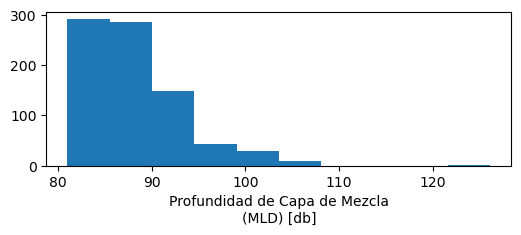

In [19]:
perfiles_ds['MLD'].plot.hist(figsize=(6,2));

#### Perfiles y MLD en gráfica integrada

MLD en todos los perfiles integrados en un solo plot de densidad vs profundidad, con el tiempo. Aquí usamos la función `scatter_plot` de `argopy`.

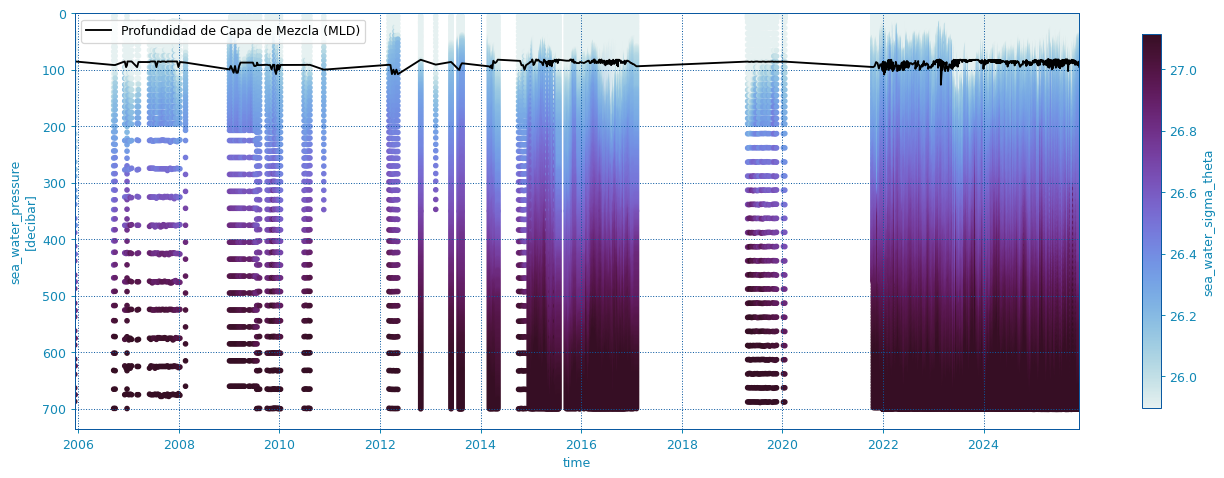

In [20]:
fig, ax, _, _ = scatter_plot(perfiles_ds, 'SIG0', cmap=cmocean.cm.dense, s=12, cbar=True);

ax.plot(perfiles_ds['TIME'], perfiles_ds['MLD'], 'k', label=perfiles_ds['MLD'].attrs['long_name'])

ax.legend(loc='upper left');

De comparación, la temperatura:

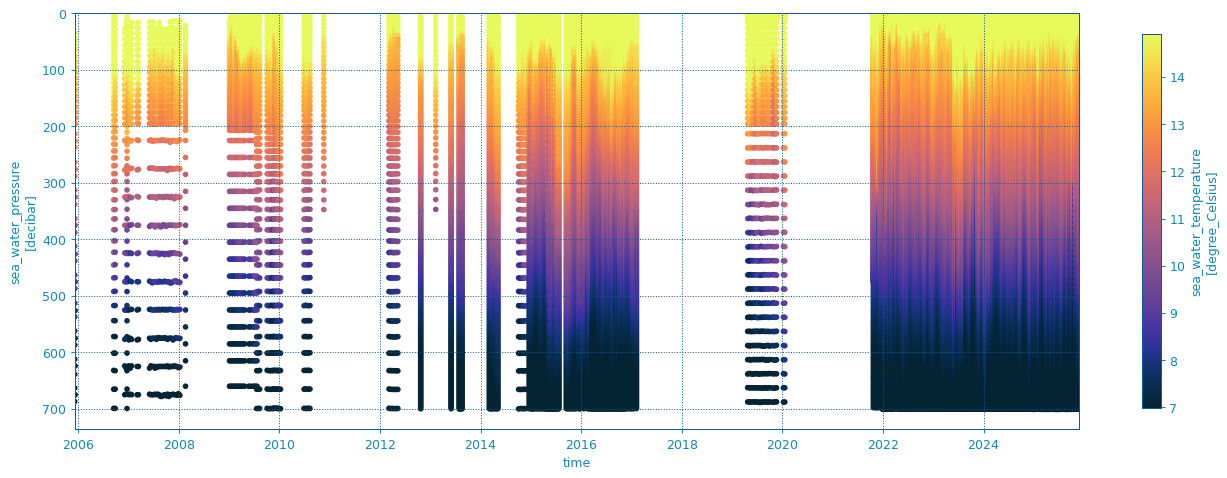

In [21]:
scatter_plot(perfiles_ds, 'TEMP', cmap=cmocean.cm.thermal, s=12, cbar=True);

#### Mapas de MLD

Usando la función `scatter_map` de `argopy`:

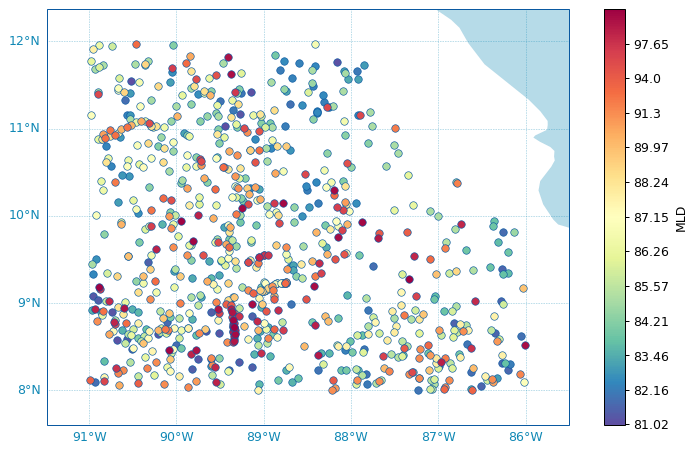

In [22]:
scatter_map(perfiles_ds.isel(N_LEVELS=0), hue='MLD', cmap='Spectral_r', traj=False, legend=False, cbar=True);

Usando `xarray`, `Matplotlib` y `cartopy` nos da más control, pero con más pasos.

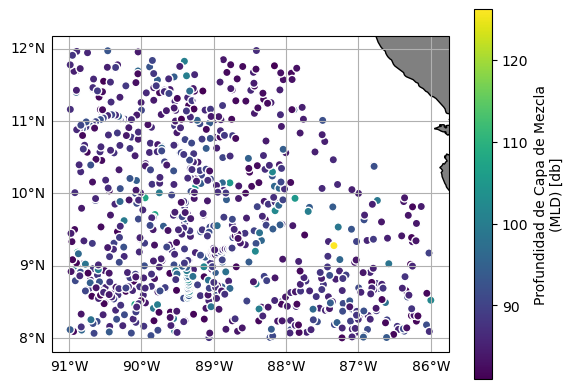

In [23]:
_, ax = plt.subplots(ncols=1, subplot_kw=dict(projection=ccrs.PlateCarree()))

perfiles_ds.plot.scatter(
    x='LONGITUDE', y='LATITUDE', hue='MLD', add_colorbar=True,
    transform=ccrs.PlateCarree(),
    ax=ax
)
ax.add_feature(cfeature.LAND, facecolor='gray')
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

In [24]:
perfiles_ds['month'] = perfiles_ds['TIME.month']

# Tenemos que reasignar "month" como una coordenada. 
# Y luego crear un "índice" para esta coordenada, que permitirá
# hacer selecciones en base al mes, como esta: perfiles_ds.sel(month=1)
perfiles_ds = perfiles_ds.set_coords("month").set_xindex('month')

perfiles_ds

<xarray.Dataset> Size: 14MB
Dimensions:          (N_PROF: 813, N_LEVELS: 551)
Coordinates:
  * N_PROF           (N_PROF) int64 7kB 25 26 295 296 27 ... 91 369 806 155 294
  * N_LEVELS         (N_LEVELS) int64 4kB 0 1 2 3 4 5 ... 546 547 548 549 550
    LATITUDE         (N_PROF) float64 7kB 10.0 10.05 8.145 ... 9.048 9.447 10.61
    LONGITUDE        (N_PROF) float64 7kB -87.0 -87.09 -87.23 ... -90.97 -88.04
    TIME             (N_PROF) datetime64[ns] 7kB 2005-12-07T10:36:00 ... 2025...
  * month            (N_PROF) int64 7kB 12 12 9 9 12 12 12 ... 11 11 11 11 11 11
Data variables: (12/17)
    CYCLE_NUMBER     (N_PROF) int64 7kB 0 0 82 83 36 37 ... 155 27 27 21 26 260
    DATA_MODE        (N_PROF) <U1 3kB 'R' 'R' 'D' 'D' 'D' ... 'R' 'A' 'R' 'A'
    DIRECTION        (N_PROF) <U1 3kB 'D' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_PROF) int64 7kB 1900379 1900379 ... 2903904 3901300
    POSITION_QC      (N_PROF) int64 7kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PRES             (N_PROF, N_LEVELS) float32 2MB 45.0 55.0 65.0 ... nan nan
    ...               ...
    TEMP             (N_PROF, N_LEVELS) float32 2MB 15.76 14.86 ... nan nan
    TEMP_ERROR       (N_PROF, N_LEVELS) float32 2MB nan nan nan ... nan nan nan
    TEMP_QC          (N_PROF) int64 7kB 1 1 2 2 1 1 2 1 1 ... 1 1 1 1 1 1 1 1 1
    TIME_QC          (N_PROF) int64 7kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    SIG0             (N_PROF, N_LEVELS) float64 4MB 25.35 25.57 ... nan nan
    MLD              (N_PROF) float32 3kB 85.0 85.0 91.3 ... 91.1 84.97 94.3
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           mayorga
    Fetched_date:         2025/11/26
    Fetched_constraints:  [x=-91.00/-86.00; y=8.00/12.00; z=0.0/350.0; t=2005...
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

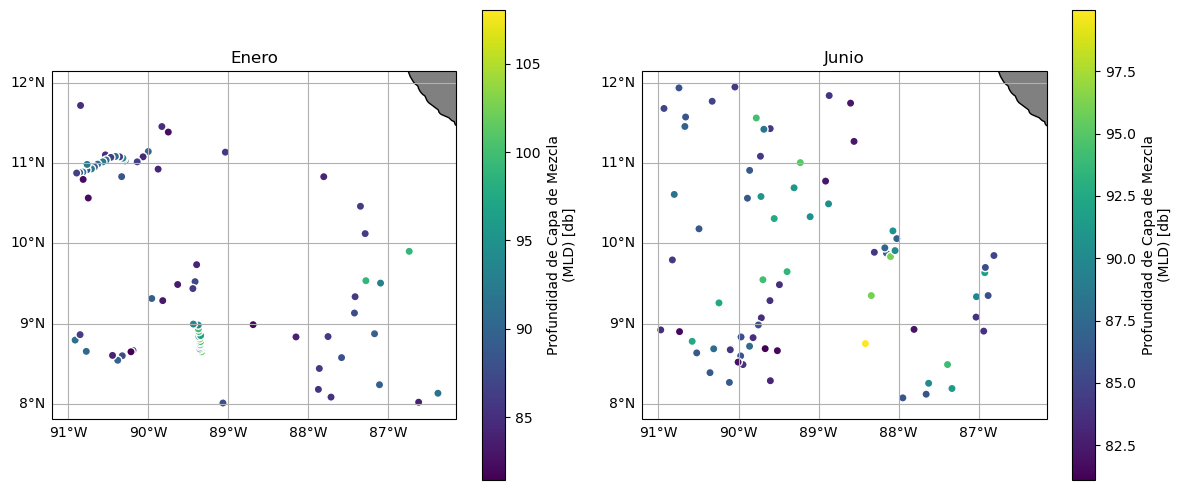

In [25]:
_, ejes = plt.subplots(
    ncols=2, sharey=True, sharex=True, figsize=(12, 5),
    subplot_kw=dict(projection=ccrs.PlateCarree())
)

# Enero
perfiles_ds.sel(month=1).plot.scatter(
    x='LONGITUDE', y='LATITUDE', hue='MLD', add_colorbar=True,
    transform=ccrs.PlateCarree(),
    ax=ejes[0]
)
ejes[0].add_feature(cfeature.LAND, facecolor='gray')
ejes[0].coastlines()
gl = ejes[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ejes[0].set_title("Enero")

# Junio
perfiles_ds.sel(month=6).plot.scatter(
    x='LONGITUDE', y='LATITUDE', hue='MLD', add_colorbar=True,
    transform=ccrs.PlateCarree(),
    ax=ejes[1]
)
ejes[1].add_feature(cfeature.LAND, facecolor='gray')
ejes[1].coastlines()
gl = ejes[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ejes[1].set_title("Junio")

plt.tight_layout();

Podríamos generar mapas más simples pero menos intuitivos con sólo `xarray` y `Matplotlib`:

```python
# Un mapa simple con plot.scatter de xarray, sin usar cartopy
perfiles_ds.plot.scatter(x='LONGITUDE', y='LATITUDE', hue='MLD', add_colorbar=True);

# O con Matplotlib directamente:
plt.scatter(x=perfiles_ds.LONGITUDE, y=perfiles_ds.LATITUDE, c=perfiles_ds.MLD, s=10);
```

## Incluir un dashboard en línea aquí mismo, con `argopy`

`argopy` integra una capacidad de generar un "dashboard" (panel de exploración) interactivo aquí en el cuaderno Jupyter, de un sitio de exploración de datos Argo en línea. Generaremos uno para una boya específica, basado en su número de plataforma.

In [26]:
np.unique(puntos_ds.PLATFORM_NUMBER.data)

array([1900379, 1902692, 2903792, 2903800, 2903880, 2903904, 3900407,
       3900410, 3900741, 3900785, 3900786, 3901155, 3901300, 4900449,
       4900762, 4902476, 4903666, 5903837, 5903872, 5904135, 5904136,
       5906478, 5906479, 5906480, 5906486, 7901042, 7901109])

In [27]:
# Esta es una boya Argo BGC activa lanzada este año, 
# por mi universidad, la Universidad de Washington
plataforma_num = 7901109

In [28]:
DataFetcher().float(plataforma_num).dashboard()

Hay un par de tipos de dashboards mas, también accesibles a través de `argopy` 

## Quería incluir algo sobre datos de oxígeno y clorofila de Argo BGC ...

Pero ya me quedé sin tiempo 😢